# Evaluate the calibration results

In [1]:
from impact_calc import *
from climada.util import log_level
log_level("WARNING")

## Plot Impact Functions

Loading hazard
2024-05-06 14:36:03,101 - climada.hazard.base - DEBUG - Loading Hazard intensity from DataArray 'flood_depth'
2024-05-06 14:36:04,496 - climada.hazard.base - WARNING - Failed to read values of 'time' as dates. Hazard.event_name will be empty strings
2024-05-06 14:36:04,501 - climada.hazard.base - DEBUG - Using default values for Hazard.fraction. No data found
2024-05-06 14:36:04,501 - climada.hazard.base - DEBUG - Using default values for Hazard.frequency. No data found
2024-05-06 14:36:04,502 - climada.hazard.base - DEBUG - Using default values for Hazard.event_id. No data found
2024-05-06 14:36:04,502 - climada.hazard.base - DEBUG - Using default values for Hazard.event_name. No data found
2024-05-06 14:36:04,503 - climada.hazard.base - DEBUG - Reading data for Hazard.date from DataArray 'time'
2024-05-06 14:36:04,503 - climada.hazard.base - DEBUG - Hazard successfully loaded. Number of events: 15
Loading exposure
2024-05-06 14:36:04,528 - climada.util.coordinates - IN

/cluster/apps/nss/gcc-8.2.0/python/3.10.4/x86_64/lib64/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


2024-05-06 14:37:48,019 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for RF
2024-05-06 14:37:48,020 - climada.entity.exposures.base - INFO - Existing centroids will be overwritten for RF
2024-05-06 14:37:48,026 - climada.entity.exposures.base - INFO - Matching 3308040 exposures with 3309696 centroids.
2024-05-06 14:37:48,471 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2024-05-06 14:37:56,398 - climada.engine.impact_calc - INFO - Calculating impact for 6778869 assets (>0) and 15 events.


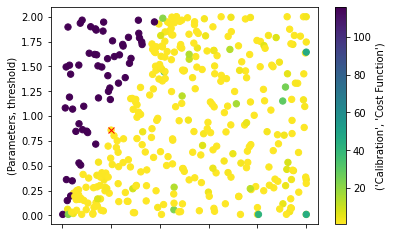

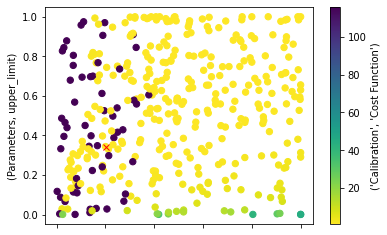

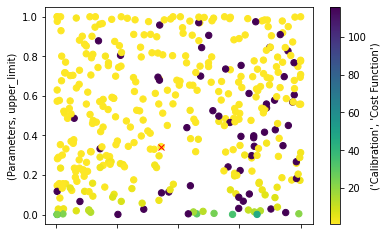

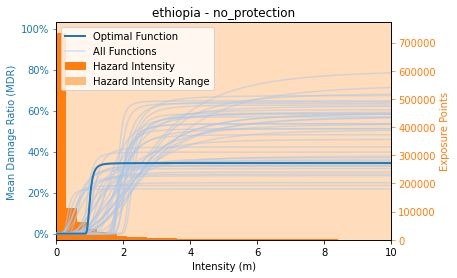

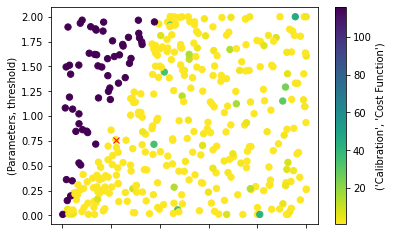

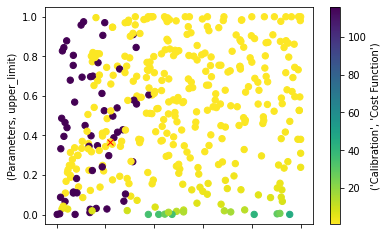

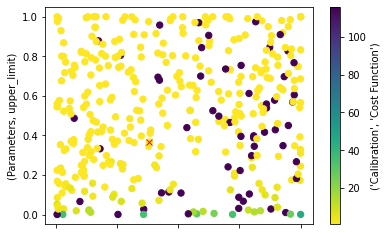

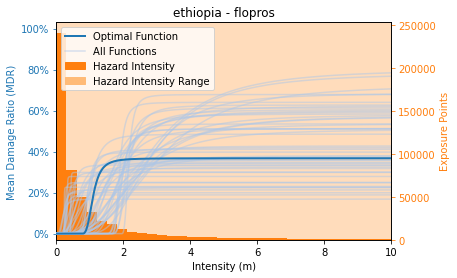

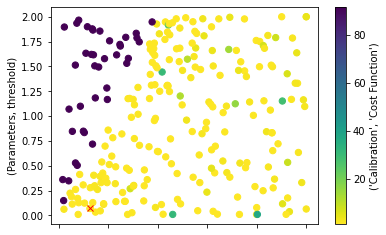

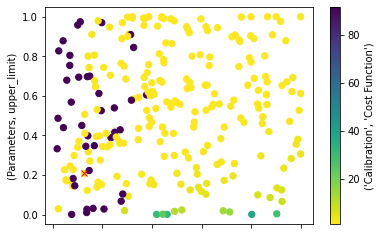

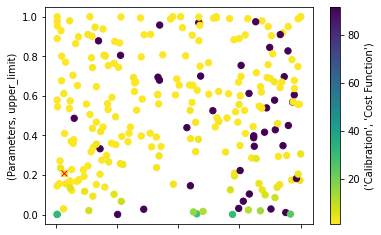

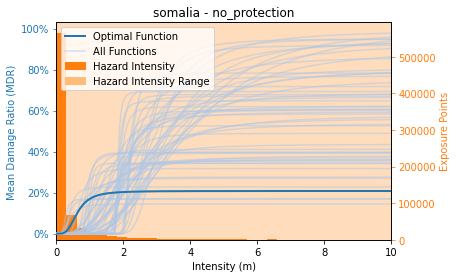

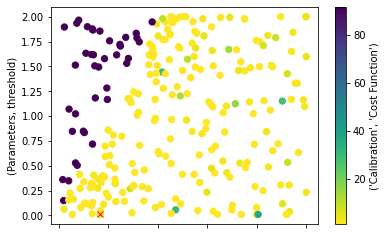

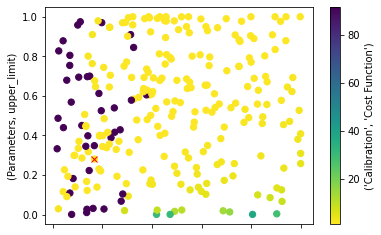

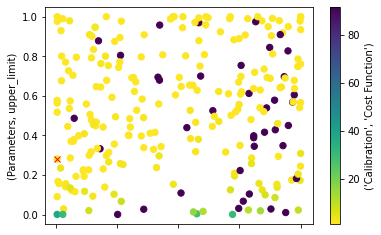

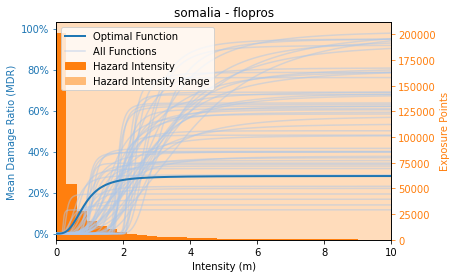

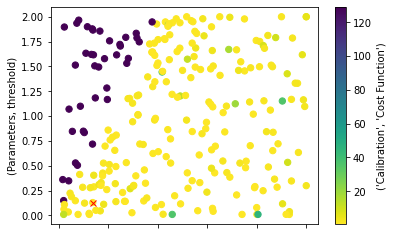

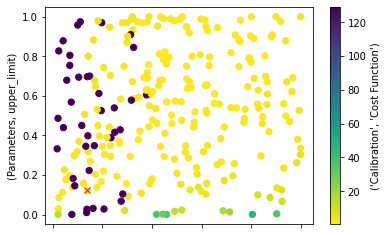

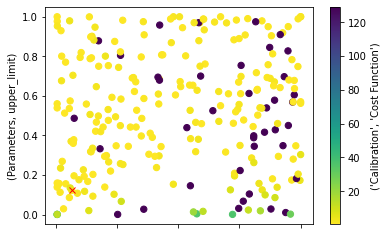

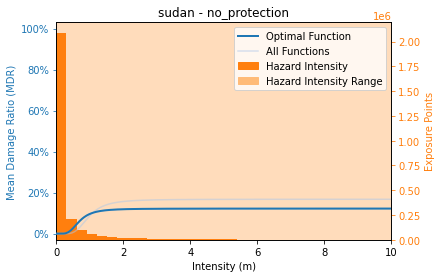

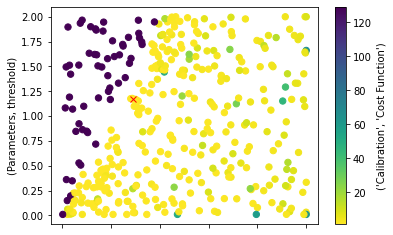

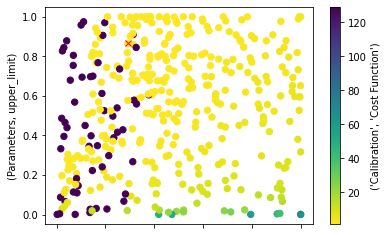

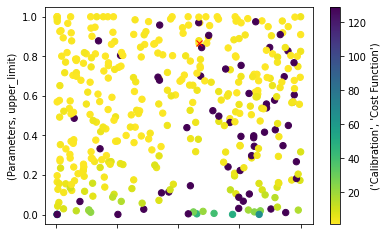

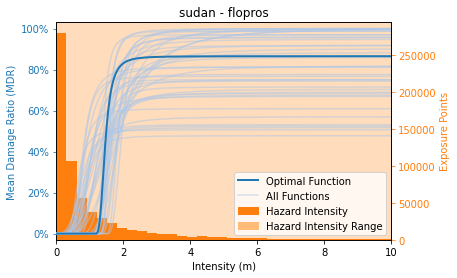

In [2]:
from itertools import product
import pandas
import matplotlib.colors as mcolors

from climada.util.calibrate import BayesianOptimizerOutputEvaluator
from climada.util.calibrate.bayesian_optimizer import (
    BayesianOptimizerOutput,
    select_best,
)

countries = ("ethiopia", "somalia", "sudan")
protection = ("no_protection", "flopros")

for ctry, prot in product(countries, protection):
    intensity = "flood_depth" if prot == "no_protection" else "flood_depth_flopros"
    inp = calibration_input(ctry, intensity, "sigmoid")
    inp.exposure = inp.exposure[2020]

    # p_space = pd.read_hdf(
    #     f"data/generated/{ctry}/calibration/sigmoid-pspace.h5", key=prot
    # ).sort_values(("Calibration", "Cost Function"))
    # params = p_space["Parameters"].iloc[0]
    # out_eval = BayesianOptimizerOutputEvaluator(
    #     output=BayesianOptimizerOutput(params, None, None), input=inp
    # )

    output = BayesianOptimizerOutput.from_hdf5(
        f"data/generated/{ctry}/sigmoid_all/pspace-{prot}.h5"
    )
    output.plot_p_space()
    out_eval = BayesianOptimizerOutputEvaluator(inp, output)
    ax = out_eval.plot_impf_variability(
        p_space_df=select_best(output.p_space_to_dataframe(), 0.1),
        plot_hist_kws={"bins": 100},
    )
    ax.set_title(f"{ctry} - {prot}")
    ax.set_xlim(left=0, right=10)
    ax.set_ylim(bottom=-3, top=103)

## Calculate Displacement Over Time

In [3]:
def impfsets_from_p_space(
    p_space_df, inp, cost_func_diff=0.1, num_samples=20, random_state=1
):
    """Return a list of impact function sets that represents the calibration uncertainty"""
    max_cost_func_val = p_space_df["Calibration", "Cost Function"].min() * (
        1 + cost_func_diff
    )
    params_within_range = p_space_df["Parameters"].loc[
        p_space_df["Calibration", "Cost Function"] <= max_cost_func_val
    ]
    params_within_range = params_within_range.sample(
        n=num_samples, replace=True, random_state=random_state
    )

    return [inp.impact_func_creator(**row) for _, row in params_within_range.iterrows()]

In [4]:
from itertools import product
import pandas as pd

from impact_calc import MultiExpImpactCalc
from climada.util import log_level
from climada.util.coordinates import country_to_iso
from climada.util.calibrate.bayesian_optimizer import BayesianOptimizerOutput

countries = ("ethiopia", "somalia", "sudan")
protection = ("no_protection", "flopros")

data_df = pd.DataFrame(
    columns=["Impact", "Year", "Country", "Protection", "Impact Func ID"]
)

for ctry, prot in product(countries, protection):
    intensity = "flood_depth" if prot == "no_protection" else "flood_depth_flopros"
    inp = calibration_input(ctry, intensity, "sigmoid")
    out = BayesianOptimizerOutput.from_hdf5(
        f"data/generated/{ctry}/sigmoid_all/pspace-{prot}.h5"
    )
    p_space = out.p_space_to_dataframe()
    # p_space = pd.read_hdf(
    #     f"data/generated/{ctry}/calibration-sigmoid-pspace.h5", key=prot
    # )

    with log_level("ERROR"):
        impacts = [
            MultiExpImpactCalc(inp.exposure, impf, inp.hazard).impact(
                assign_centroids=False, save_mat=False
            )
            for impf in impfsets_from_p_space(p_space, inp)
        ]

    for idx, impact in enumerate(impacts):
        data = pd.DataFrame.from_records(
            {
                "Impact": impact.at_event,
                "Year": impact.event_id,
                "Country": country_to_iso(ctry, representation="alpha3"),
                "Protection": prot,
                "Impact Func ID": idx,
            }
        )
        data_df = pd.concat([data_df, data], axis=0, ignore_index=True)

data_df

Loading hazard
2024-05-06 14:38:04,343 - climada.hazard.base - DEBUG - Loading Hazard intensity from DataArray 'flood_depth'
2024-05-06 14:38:04,914 - climada.hazard.base - WARNING - Failed to read values of 'time' as dates. Hazard.event_name will be empty strings
2024-05-06 14:38:04,916 - climada.hazard.base - DEBUG - Using default values for Hazard.fraction. No data found
2024-05-06 14:38:04,917 - climada.hazard.base - DEBUG - Using default values for Hazard.frequency. No data found
2024-05-06 14:38:04,918 - climada.hazard.base - DEBUG - Using default values for Hazard.event_id. No data found
2024-05-06 14:38:04,918 - climada.hazard.base - DEBUG - Using default values for Hazard.event_name. No data found
2024-05-06 14:38:04,919 - climada.hazard.base - DEBUG - Reading data for Hazard.date from DataArray 'time'
2024-05-06 14:38:04,920 - climada.hazard.base - DEBUG - Hazard successfully loaded. Number of events: 15
Loading exposure
2024-05-06 14:38:04,989 - climada.util.coordinates - IN

,Impact,Year,Country,Protection,Impact Func ID
0,24617.359974,2008,ETH,no_protection,0
1,15009.237788,2009,ETH,no_protection,0
2,102301.217158,2010,ETH,no_protection,0
3,35819.294771,2011,ETH,no_protection,0
4,51391.61232,2012,ETH,no_protection,0
...,...,...,...,...,...
1795,125974.618293,2018,SDN,flopros,19
1796,1498904.492605,2019,SDN,flopros,19
1797,1683336.786973,2020,SDN,flopros,19
1798,259585.11275,2021,SDN,flopros,19


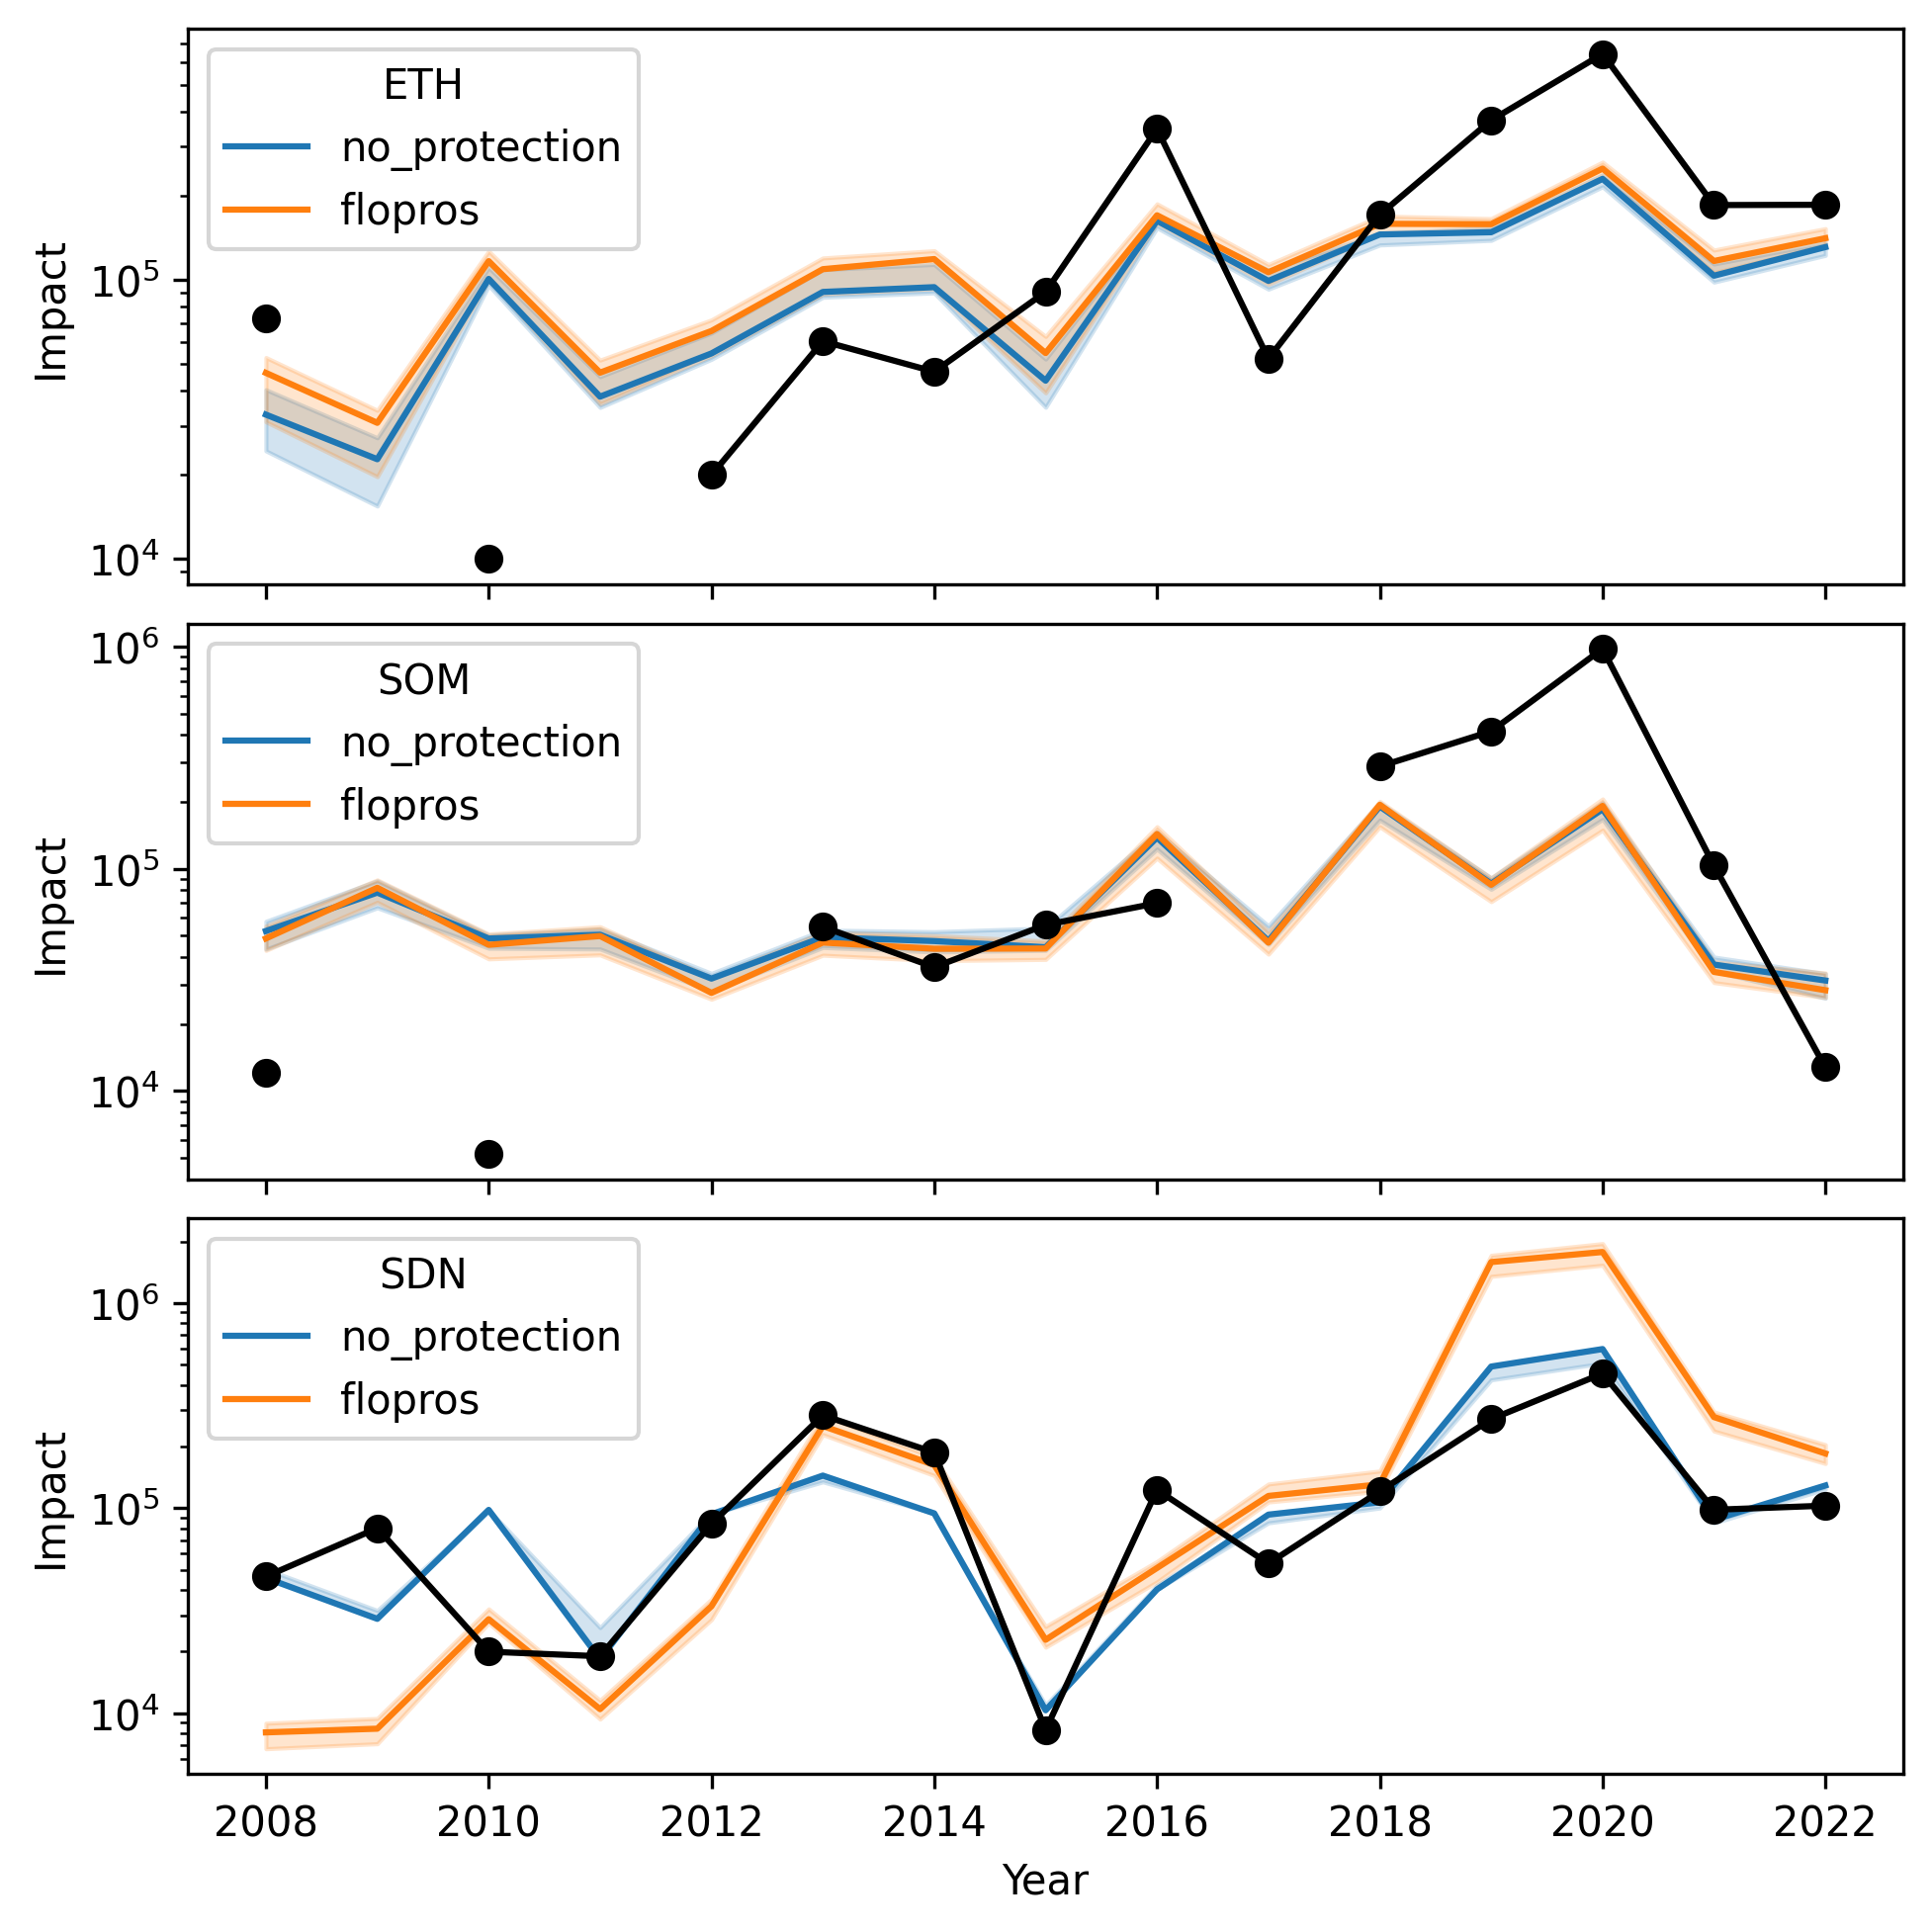

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(
    3, 1, constrained_layout=True, dpi=300, figsize=(6.4, 6.4), sharex=True
)
for country, ax in zip(data_df["Country"].unique(), axes):
    sns.lineplot(
        ax=ax,
        data=data_df.loc[data_df["Country"] == country],
        x="Year",
        y="Impact",
        hue="Protection",
        errorbar=("pi", 50),
        estimator="median",
        # legend=False if ax is not axes[0] else True,
    )
    data_displ = load_yearly_displacement_data(country, ignore_zero_impact=True)
    ax.plot(
        data_displ.index,
        data_displ[country_to_iso(country, representation="numeric")],
        color="k",
        marker="o",
        ls=None,
    )
    ax.set_yscale("log")
    ax.get_legend().set_title(country)

In [6]:
data_df.to_csv("displacement_year.csv", index=False)

In [7]:
pd.read_csv("displacement_year.csv")

,Impact,Year,Country,Protection,Impact Func ID
0,2.461736e+04,2008,ETH,no_protection,0
1,1.500924e+04,2009,ETH,no_protection,0
2,1.023012e+05,2010,ETH,no_protection,0
3,3.581929e+04,2011,ETH,no_protection,0
4,5.139161e+04,2012,ETH,no_protection,0
...,...,...,...,...,...
1795,1.259746e+05,2018,SDN,flopros,19
1796,1.498904e+06,2019,SDN,flopros,19
1797,1.683337e+06,2020,SDN,flopros,19
1798,2.595851e+05,2021,SDN,flopros,19


In [8]:
load_yearly_displacement_data("SOM", ignore_zero_impact=True)

,706
year,
2008,12000.0
2009,NaN
2010,5200.0
2011,NaN
2012,NaN
2013,54800.0
2014,36040.0
2015,55900.0
2016,70000.0


In [9]:
import numpy as np
from scipy.stats import gumbel_r


def calc_pmd(at_event, return_periods):
    # Sort descendingly the impacts per events
    sort_idxs = np.argsort(at_event)[::-1]
    # Calculate exceedence frequency
    exceed_freq = np.cumsum(np.ones_like(at_event, dtype="float") / at_event.size)
    # Set return period and impact exceeding frequency
    ifc_return_per = 1 / exceed_freq[::-1]
    ifc_impact = at_event[sort_idxs][::-1]

    return np.interp(return_periods, ifc_return_per, ifc_impact)


def calc_pmd_full(at_event):
    # Sort descendingly the impacts per events
    sort_idxs = np.argsort(at_event)[::-1]
    # Calculate exceedence frequency
    exceed_freq = np.cumsum(np.ones_like(at_event, dtype="float") / at_event.size)
    # Set return period and impact exceeding frequency
    ifc_return_per = 1 / exceed_freq[::-1]
    ifc_impact = at_event[sort_idxs][::-1]

    return ifc_return_per, ifc_impact

In [10]:
grouped = data_df.groupby(["Country", "Protection", "Impact Func ID"])

Total displacement

In [11]:
from climada.util.coordinates import country_to_iso

rec = [
    name + (data_df.loc[idx, "Impact"].sum(),) for name, idx in grouped.groups.items()
]
sum_df = pd.DataFrame.from_records(
    rec, columns=["Country", "Protection", "Impact Func ID", "Total Impact"]
)
sum_df = pd.concat(
    [
        sum_df,
        pd.DataFrame.from_records(
            [
                (
                    ctry,
                    "Reported",
                    0,
                    load_yearly_displacement_data(ctry)[
                        country_to_iso(ctry, "numeric")
                    ].sum(),
                )
                for ctry in ["ETH", "SOM", "SDN"]
            ],
            columns=["Country", "Protection", "Impact Func ID", "Total Impact"],
        ),
    ],
    axis=0,
    ignore_index=True,
)
sum_df

,Country,Protection,Impact Func ID,Total Impact
0,ETH,flopros,0,1.491170e+06
1,ETH,flopros,1,1.622013e+06
2,ETH,flopros,2,2.023403e+06
3,ETH,flopros,3,1.571427e+06
4,ETH,flopros,4,1.412835e+06
...,...,...,...,...
118,SOM,no_protection,18,1.134808e+06
119,SOM,no_protection,19,1.141061e+06
120,ETH,Reported,0,2.257762e+06
121,SOM,Reported,0,2.034136e+06


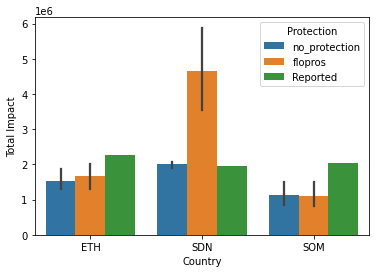

In [12]:
ax = sns.barplot(
    data=sum_df,
    x="Country",
    y="Total Impact",
    hue="Protection",
    errorbar="pi",
    hue_order=["no_protection", "flopros", "Reported"],
)
# ax.set_yscale("log")

Average Annual Displacement

Text(0, 0.5, 'AAD')

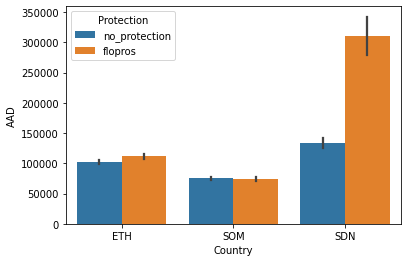

In [13]:
ax = sns.barplot(
    data=data_df,
    x="Country",
    y="Impact",
    hue="Protection",
    errorbar="se",
    estimator="mean",
    hue_order=["no_protection", "flopros"],
)
# ax.set_yscale("log")
ax.set_ylabel("AAD")

In [16]:
return_periods = [2, 5, 10]
rec = []
for name, idx in grouped.groups.items():
    # country, protection, func_id = name
    values = data_df.loc[idx, "Impact"]
    pmd = calc_pmd(values.to_numpy(dtype="float"), return_periods)
    for rp, val in zip(return_periods, pmd):
        rec.append(name + (rp, val))

pmd_df = pd.DataFrame.from_records(
    rec, columns=["Country", "Protection", "Impact Func ID", "Return Period", "PMD"]
)
pmd_df

,Country,Protection,Impact Func ID,Return Period,PMD
0,ETH,flopros,0,2,102965.704980
1,ETH,flopros,0,5,148960.675070
2,ETH,flopros,0,10,191173.264250
3,ETH,flopros,1,2,115855.353480
4,ETH,flopros,1,5,149744.108670
...,...,...,...,...,...
355,SOM,no_protection,18,5,131567.908222
356,SOM,no_protection,18,10,187078.298808
357,SOM,no_protection,19,2,55610.727149
358,SOM,no_protection,19,5,144868.190908


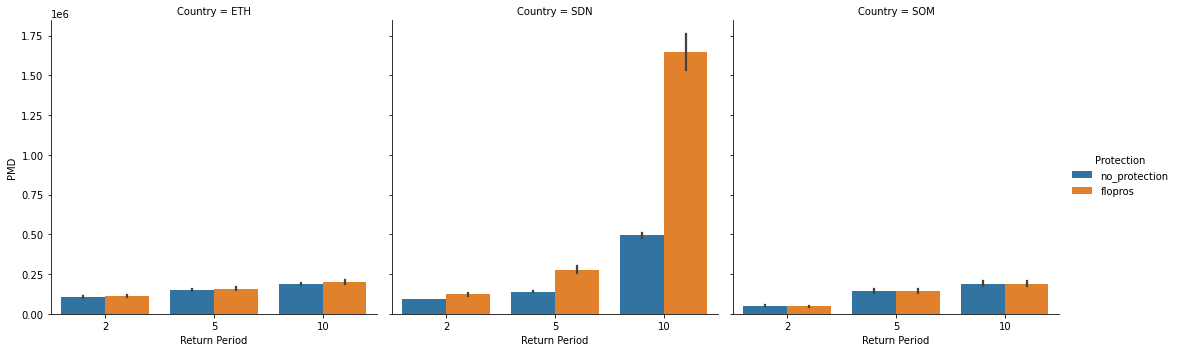

In [17]:
facet = sns.catplot(
    data=pmd_df,
    x="Return Period",
    y="PMD",
    hue="Protection",
    col="Country",
    # errorbar=("pi", 50),
    errorbar="ci",
    hue_order=["no_protection", "flopros"],
    kind="bar",
    # palette={"no_protection": "C0", "flopros": "C1"},
)
# facet.set(yscale="log")

PMD Curve Fitting

In [ ]:
data_df.iloc[0:15]

In [ ]:
pmd_df_select = pmd_df.loc[
    (pmd_df["Country"] == "ETH")
    & (pmd_df["Protection"] == "no_protection")
    & (pmd_df["Impact Func ID"] == 0)
]

In [ ]:
from scipy.stats import gumbel_r

loc, scale = gumbel_r.fit(data_df.iloc[0:15]["Impact"].to_numpy(), method="MM")

In [ ]:
gumb = gumbel_r(loc, scale)

In [ ]:
x = np.linspace(gumb.ppf(0.01), gumb.ppf(0.99), 100)
x

In [ ]:
plt.plot(x, 1 / gumb.sf(x))
plt.plot(x, 1 / (1 - gumb.cdf(x)))

In [ ]:
1 / gumb.sf(257774.37378822)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(1 / gumb.sf(x), x)


rp, impacts = calc_pmd_full(data_df.iloc[0:15]["Impact"].to_numpy())
plt.plot(rp, impacts, "-o")
# plt.plot(pmd_df_select["Return Period"], pmd_df_select["PMD"], "-o")
plt.yscale("log")
plt.xscale("log")

In [30]:
# from climada.util.coordinates import country
import pycountry
from scipy.stats import rv_continuous
from scipy.stats import gumbel_r

def compare_return_periods(data: pd.DataFrame, gev: rv_continuous, method: str = "MLE"):

    for name, idx in data.groupby(["Country"]).groups.items():
        fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, constrained_layout=True)
        fig.suptitle(name)
        group = data.loc[idx]

        observed = load_yearly_displacement_data(
            pycountry.countries.get(
                alpha_3=name
            ).name
        )
        rp_obs, imp_obs = calc_pmd_full(observed[country_to_iso(name, "numeric")].to_numpy())
        # Plot observations
        for ax in axes:
            ax.plot(rp_obs, imp_obs, "o-", color="k", zorder=10)
        axes[0].set_xscale("log")
        axes[0].set_yscale("log")
        axes[0].autoscale(False)
        axes[1].autoscale(False)

        for prot, color in zip(group["Protection"].unique(), ("C0", "C1")):
            group_prot = group.loc[group["Protection"] == prot]
            for idx in group_prot.groupby(["Impact Func ID"]).groups.values():

                # rp, impacts = calc_pmd_full(values["Impact"])
                values = group_prot.loc[idx, "Impact"].to_numpy(dtype="float")

                # Plot calculated RPs
                rp, imp = calc_pmd_full(values)
                mask = rp > 1
                axes[0].plot(rp[mask], imp[mask], "o-", color=color, alpha=0.5, markersize=2)

                # Plot Gumbel fit
                params = gev.fit(values, method=method)
                # print("c: {0}, loc: {1}, scale: {2}".format(*params))
                # print(*params)
                func = gev(*params)
                # imp = np.linspace(gumb.ppf(0.01), gumb.ppf(0.99), 100)
                imp = np.linspace(np.min(imp), np.max(imp))
                rp = 1 / func.sf(imp)
                mask = rp > 1
                axes[1].plot(rp[mask], imp[mask], color=color, alpha=0.5)

        axes[0].autoscale_view()

In [82]:
import numpy as np

def plot_fitted_distribution(values: np.ndarray, gev: rv_continuous, ax, method: str = "MLE", **plot_kwargs):
    sns.kdeplot(x=values, ax=ax, ls="--", **plot_kwargs)
    sns.rugplot(x=values, ax=ax, height=0.05, **plot_kwargs)
    
    params = gev.fit(values, method=method)
    # print(params)
    func = gev(*params)
    x = np.linspace(func.ppf(0.01), func.ppf(0.99), 100)
    # print(func.ppf(0.01), func.ppf(0.99))
    # sns.lineplot(x=x, y=func.pdf(x), ax=ax, **plot_kwargs)
    ax.plot(x, func.pdf(x), **plot_kwargs)

(0.0, 2234076.3098177956)

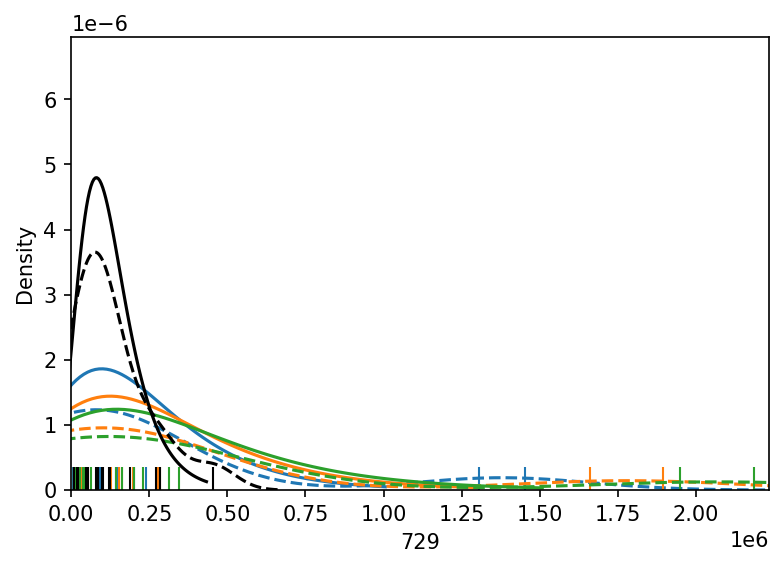

In [91]:
import scipy.stats as stat

country = "SDN"
data_subs = data_df.loc[(data_df["Country"] == country) & (data_df["Protection"] == "flopros")]

fig, ax = plt.subplots(dpi=150)
for func_id in range(3):
    plot_fitted_distribution(
        data_subs.loc[data_subs["Impact Func ID"] == func_id, "Impact"].to_numpy(dtype="float"),
        gev=stat.gumbel_r,
        ax=ax,
        method="MLE",
        color=f"C{func_id}"
    )
data_true = load_yearly_displacement_data(country, ignore_zero_impact=False)
plot_fitted_distribution(
    data_true[data_true.columns[0]],
    gev=stat.gumbel_r,
    ax=ax,
    method="MLE",
    color="k",
)
ax.set_xlim(0, data_subs["Impact"].max())

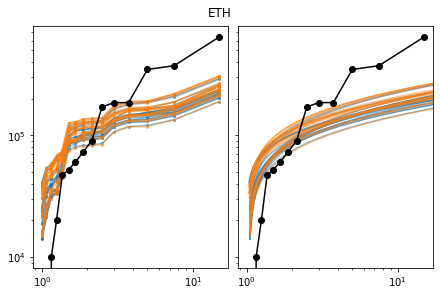

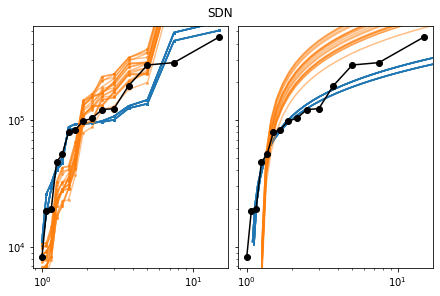

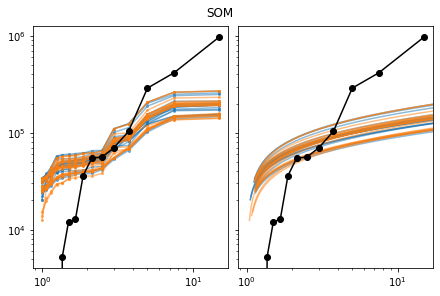

In [31]:
compare_return_periods(data_df, gev=gumbel_r)